In [25]:
import os

from matplotlib import pyplot as plt

In [26]:
l1_graph_collections = "data/collections/l1_graph.out"
l2_graph_collections = "data/collections/l2_graph.out"

l1_graph_video = "data/video/l1_graph_rel100_ef100.out"
l2_graph_video = "data/video/l2_graph_rel100_ef100.out"

In [33]:
cmd_template = (
    "./RPG --mode query --baseSize 1000000 --querySize 1000"
    " --query data/{dataset}/data/model_scores/scores_test.bin --inputGraph {inputGraph}"
    " --efSearch {efSearch} --topK 5 --output data/{dataset}/result.txt --gtQueries 1000 --gtTop 100 "
    "--groundtruth data/{dataset}/data/model_scores/groundtruth.bin"
)

def measure_performance(graph, dataset, ef_ticks):
    relevances = []
    recalls = []
    times = []
    model_evals = []
    for ef in ef_ticks:
        cmd = cmd_template.format(inputGraph=graph, dataset=dataset, efSearch=ef)
        with os.popen(cmd) as out:
            for line in out:
                for arr, prefix, suff_len in [
                    (relevances, "Average relevance: ", 1),
                    (recalls, "Recall@5: ", 1),
                    (times, "Average query time: ", 3),
                    (model_evals, "Average number of model computations: ", 1)
                ]:
                    if line.startswith(prefix):
                        arr.append(float(line[len(prefix):-suff_len]))
    return {
        "rel": relevances,
        "recall": recalls,
        "time": times,
        "evals": model_evals
    }

In [34]:
ef_ticks = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]
l1_results = measure_performance(l1_graph_video, "video", ef_ticks)
l2_results = measure_performance(l2_graph_video, "video", ef_ticks)


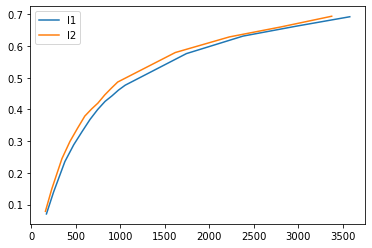

In [35]:
plt.plot(l1_results["evals"], l1_results["recall"], label="l1")
plt.plot(l2_results["evals"], l2_results["recall"], label="l2")
plt.legend()
plt.show()